In [1]:
# Подключение к Google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
PATH = '/content/drive/My Drive/GU_neural_network/'

In [0]:
import sys
sys.path.append(PATH)

## Практическое задание

<ol>
    <li>Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?</li>
</ol>


#### Библиотека функций и нейронной сети

In [4]:
'''
Исходный код к уроку 1.
Построение двухслойной нейронный сети для классификации цветков ириса
'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split


### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = layer2[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
class NN2IrisPredict:
    w0, w1 = None, None
    # скорость обучения (learning rate)
    n = 0.1
    epoch = 100000

    def __init__(self, size=5, learning_rate=0.1, epoch=100000):
      self.init_data()
      self.init_params(size, learning_rate, epoch)

    def init_data(self):
      ### Шаг 2. Подготовка тренировочных данных
      # получения данных из csv файла. укажите здесь путь к файлу Iris.csv
      iris_data = pd.read_csv(os.path.join(PATH,"Iris.csv"))
      # print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

      # репрезентация данных в виде графиков
      g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
      # plt.show() # расскоментируйте, чтобы посмотреть

      # замена текстовых значений на цифровые
      iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

      # формирование входных данных
      columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
      x = pd.DataFrame(iris_data, columns=columns)
      x = normalize(x.values)

      # формирование выходных данных(результатов)
      columns = ['Species']
      y = pd.DataFrame(iris_data, columns=columns)
      y = y.values
      y = y.flatten()
      y = to_one_hot(y)

      # Разделение данных на тренировочные и тестовые
      self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(x, y, test_size=0.33, random_state=1)

    def init_params(self, size=5, learning_rate=0.1, epoch=100000):
        ### Шаг 3. Обученние нейронной сети
        # присваевание случайных весов
        np.random.seed(1)
        self.w0 = 2*np.random.random((4, size)) - 1 # для входного слоя   - 4 входа, size выхода
        self.w1 = 2*np.random.random((size, 3)) - 1 # для внутреннего слоя - size входов, 3 выхода
        self.n = learning_rate
        self.epoch = epoch

    def predict(self, mode='test'):
          if mode=='test':
            x_value = self.X_test
            y_value = self.y_test
          else:
            x_value = self.X_train
            y_value = self.y_train           
          layer0 = x_value
          layer1 = sigmoid(np.dot(layer0, self.w0))
          layer2 = sigmoid(np.dot(layer1, self.w1))

          layer2_error = y_value - layer2
          error = np.mean(np.abs(layer2_error))
          accuracy = (1 - error) * 100
          print(f"Точность нейронной сети на {mode}: {str(round(accuracy,2))}%")
          return accuracy

    def train(self, size=5, learning_rate=0.1, epoch=100000, use_plot=True):
      self.init_params(size, learning_rate, epoch)
      # массив для ошибок, чтобы потом построить график
      errors = []

      # процесс обучения
      for i in range(self.epoch):

          # прямое распространение(feed forward)
          layer0 = self.X_train
          layer1 = sigmoid(np.dot(layer0, self.w0))
          layer2 = sigmoid(np.dot(layer1, self.w1))

          # обратное распространение(back propagation) с использованием градиентного спуска
          layer2_error =  self.y_train - layer2
          layer2_delta = layer2_error * sigmoid_deriv(layer2)
          
          layer1_error = layer2_delta.dot(self.w1.T)
          layer1_delta = layer1_error * sigmoid_deriv(layer1)
          
          self.w1 += layer1.T.dot(layer2_delta) * self.n
          self.w0 += layer0.T.dot(layer1_delta) * self.n
          
          error = np.mean(np.abs(layer2_error))
          errors.append(error)
          accuracy = (1 - error) * 100
      if use_plot:
        ### Шаг 4. Демонстрация полученных результатов
        # черчение диаграммы точности в зависимости от обучения
        plt.plot(errors)
        plt.xlabel('Обучение')
        plt.ylabel('Ошибка')
        plt.show() # расскоментируйте, чтобы посмотреть 

        self.predict(mode='train')      

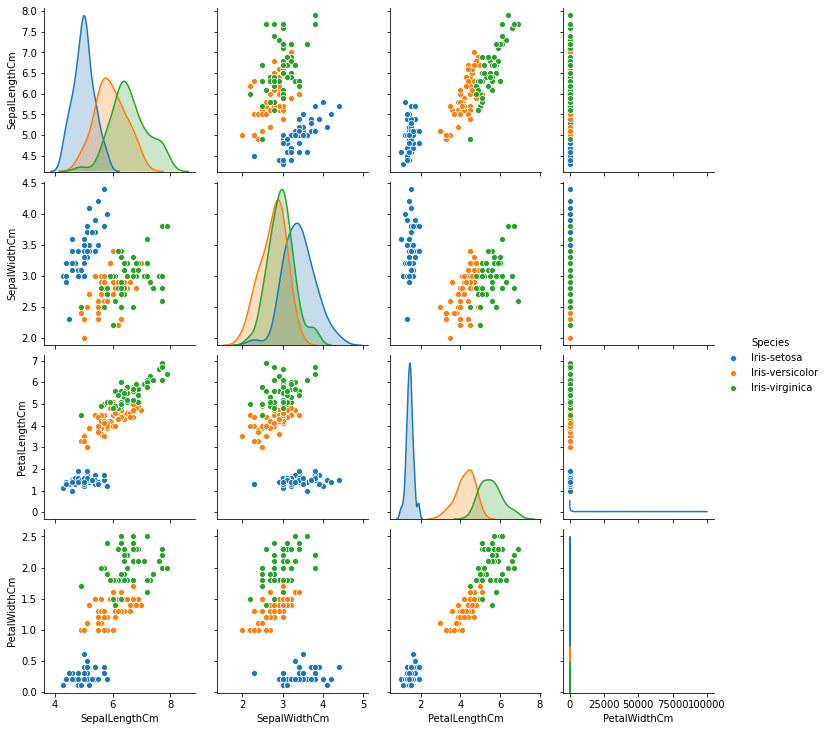

Точность нейронной сети на train: 96.84%
Точность нейронной сети на test: 98.22%


In [6]:
nn = NN2IrisPredict()
nn.train()
spam = nn.predict()

#### Функция обучения и оценки:

In [0]:
def analys(nn, size=5, learning_rate=0.1, epoch=100000):
    print('-'*100)
    print(f'Параметры модели size={size} learning_rate={learning_rate} epoch={epoch}')
    %time nn.train(size=size, learning_rate=learning_rate, epoch=epoch, use_plot=False)
    acc_train = nn.predict(mode='train')
    acc_test = nn.predict()

#### Анализ влияния количества нейронов на точность:

In [8]:
sizes = [1, 2, 3, 4, 5, 7, 10, 15]
for size in sizes:
  analys(nn, size=size)

----------------------------------------------------------------------------------------------------
Параметры модели size=1 learning_rate=0.1 epoch=100000
CPU times: user 8.95 s, sys: 23 ms, total: 8.98 s
Wall time: 9.04 s
Точность нейронной сети на train: 56.83%
Точность нейронной сети на test: 61.0%
----------------------------------------------------------------------------------------------------
Параметры модели size=2 learning_rate=0.1 epoch=100000
CPU times: user 10.8 s, sys: 12.3 ms, total: 10.8 s
Wall time: 10.8 s
Точность нейронной сети на train: 76.49%
Точность нейронной сети на test: 75.95%
----------------------------------------------------------------------------------------------------
Параметры модели size=3 learning_rate=0.1 epoch=100000
CPU times: user 11.2 s, sys: 10.1 ms, total: 11.2 s
Wall time: 11.2 s
Точность нейронной сети на train: 88.72%
Точность нейронной сети на test: 82.95%
----------------------------------------------------------------------------------

Вывод: При прочих равных параметрах модели, начиная с 4 нейронов во внутреннем слое точность перестают расти. 

#### Анализ влияния шага обучения на точность:

In [9]:
learning_rates = [10, 1, 0.1, 0.01, 0.001]
for learning_rate in learning_rates:
  analys(nn, size=4, learning_rate=learning_rate)

----------------------------------------------------------------------------------------------------
Параметры модели size=4 learning_rate=10 epoch=100000
CPU times: user 11.3 s, sys: 13.1 ms, total: 11.3 s
Wall time: 11.3 s
Точность нейронной сети на train: 50.0%
Точность нейронной сети на test: 50.0%
----------------------------------------------------------------------------------------------------
Параметры модели size=4 learning_rate=1 epoch=100000
CPU times: user 11.5 s, sys: 16 ms, total: 11.5 s
Wall time: 11.5 s
Точность нейронной сети на train: 58.5%
Точность нейронной сети на test: 57.0%
----------------------------------------------------------------------------------------------------
Параметры модели size=4 learning_rate=0.1 epoch=100000
CPU times: user 11.9 s, sys: 17 ms, total: 11.9 s
Wall time: 11.9 s
Точность нейронной сети на train: 97.04%
Точность нейронной сети на test: 98.01%
------------------------------------------------------------------------------------------

Вывод: Шаг обучения 10 и 1 слишком большие для обучения, что не позволяет градиентному списку найти минимум весов, а шаги 0.01 и 0.001  малы и сеть не успевает обучится за 100000 итераций цикла.

#### Анализ влияния количества итераций обучения на точность и время обучения:

In [10]:
epoches = [10**3, 10**4, 10**5, 10**6, 10**7]
for epoch in epoches:
  analys(nn, size=4, learning_rate=0.1, epoch=epoch)

----------------------------------------------------------------------------------------------------
Параметры модели size=4 learning_rate=0.1 epoch=1000
CPU times: user 117 ms, sys: 1e+03 ns, total: 117 ms
Wall time: 119 ms
Точность нейронной сети на train: 89.45%
Точность нейронной сети на test: 88.98%
----------------------------------------------------------------------------------------------------
Параметры модели size=4 learning_rate=0.1 epoch=10000
CPU times: user 1.19 s, sys: 5.02 ms, total: 1.19 s
Wall time: 1.19 s
Точность нейронной сети на train: 96.6%
Точность нейронной сети на test: 97.71%
----------------------------------------------------------------------------------------------------
Параметры модели size=4 learning_rate=0.1 epoch=100000
CPU times: user 11.8 s, sys: 18 ms, total: 11.8 s
Wall time: 11.8 s
Точность нейронной сети на train: 97.04%
Точность нейронной сети на test: 98.01%
------------------------------------------------------------------------------------

Вывод: С увеличением количества итераций обучения точность возрастает. Но при этом время обучения растет значительно быстрее, чем точность. В конкретном случае лучше остановиться на 10**6.